# Import Libraries and Set Compute Params

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Tensorflow Hack to get it to work with RTX cards
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# GPU Precision
T_TYPE = tf.float16

# Simulate Virus Spread

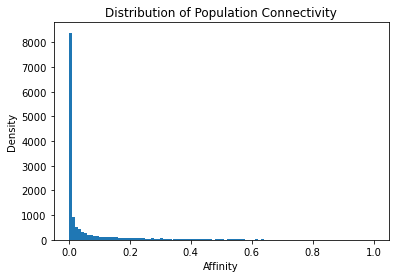

In [25]:
# Instantiate the population characteristics

# Number of people considered
pop = 14000

def bust(dist, max_val):
    '''
    Takes a probability distribution and sets any values 
    larger than max_val to zero
    '''
    busted = dist > max_val
    dist = dist*(1.0 - tf.cast(busted, dtype=T_TYPE))
    return dist
    

dist = bust(tf.random.gamma((pop, pop), alpha=0.15, beta=2, dtype=T_TYPE), max_val=1)

# Plot the distribution
plt.hist(dist.numpy()[0, :], bins=100)
plt.xlabel('Affinity')
plt.ylabel('Density')
plt.title('Distribution of Population Connectivity')


# Transmission probabilities (you cannot infect yourself)
I = tf.eye(pop, pop, dtype=T_TYPE)
# Affinity matrix (how close people are to each other)
A = dist*(1-I) 

In [33]:
# All individuals have 
vec_days_infected = tf.zeros((pop))

# Someone is infectious if they have been infected for > 2 days and < 12 days
period_incubation = 2
#period_infectious = 9
period_infectious = 12
#period_infectious = 20

# Simulation Parameters
num_days = 365
init_infected_prop = 0.001
trans_thresh = 0.85

# Reporting params (report every 20% finished)
report_proportion = 0.2

# Start off by having people be infected
init_infected = np.zeros((pop))
init_infected[:int(init_infected_prop*pop)] = 1
vec_days_infected += init_infected

# Here we store variables to graph
graph_num_infectious = []
graph_num_susceptible = []
graph_num_recovered = []
graph_num_newinfections = []

for day in range(num_days):
    # Report how far we are
    if(day % int(report_proportion*num_days) == 0):
        print('Calculating {0}%'.format(day/num_days*100))
    # Find out who is now infectious
    vec_infectious = tf.cast(tf.logical_and(vec_days_infected > period_incubation, vec_days_infected < period_infectious), dtype=T_TYPE)
    # Increment days infected counter
    vec_days_infected += tf.clip_by_value(vec_days_infected, 0, 1)
    # Find out who is susceptible (not yet had the virus)
    vec_susceptible = tf.cast(vec_days_infected < 1, dtype=T_TYPE)
    # Find out who has recovered
    vec_recovered = tf.cast(vec_days_infected > period_infectious, T_TYPE)
    
    # Get randomness
    rand = tf.random.uniform(A.shape, dtype=T_TYPE)
    # Multiply by the affinity matrix to get transmission probabilities
    trans_probs = rand*A
    
    # Find out who has transmitted 
    trans_mat = tf.cast(trans_probs > trans_thresh, dtype=T_TYPE)
    # If person A is infectious, person B is susceptible, AND their is a transmitive contact, B is now infected
    who_infected_who = vec_infectious[:, tf.newaxis]*vec_susceptible[tf.newaxis, :]*trans_mat
    
    # Reduce because we just care about who got infected (and how many times lol)
    transmitees = tf.reduce_sum(who_infected_who, axis=0)
    # Count how many people a certain person infected 
    transmissions = tf.reduce_sum(who_infected_who, axis=1)
    
    # Actually infect people 
    newly_infected = tf.cast(tf.logical_and(tf.logical_not(tf.cast(vec_days_infected, dtype=tf.bool)), tf.cast(transmitees, tf.bool)), tf.float32)
    vec_days_infected += newly_infected
    
    # Add today's infections 
    #print(day, vec_infected)
    
    # Record results
    graph_num_newinfections.append(tf.reduce_sum(newly_infected).numpy())
    graph_num_infectious.append(tf.reduce_sum(vec_infectious).numpy())
    graph_num_susceptible.append(tf.reduce_sum(vec_susceptible).numpy())
    graph_num_recovered.append(tf.reduce_sum(vec_recovered).numpy())

Calculating 0.0%
Calculating 20.0%
Calculating 40.0%
Calculating 60.0%
Calculating 80.0%


# Plot the Results

Text(0.5, 1.0, 'Infections Over Time')

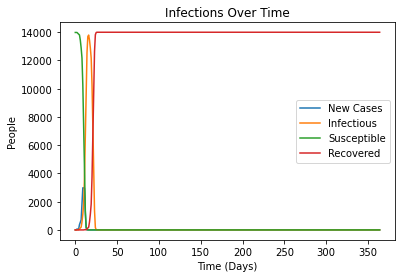

In [34]:
plot_dict = {'New Cases': graph_num_newinfections, 
            'Infectious': graph_num_infectious, 
            'Susceptible': graph_num_susceptible,
            'Recovered': graph_num_recovered}
for key in plot_dict:
    y_values = np.array(plot_dict[key])
    #plt.plot(np.arange(num_days), y_values/np.max(y_values))
    plt.plot(np.arange(num_days), y_values)

plt.legend(plot_dict.keys())
plt.xlabel('Time (Days)')
plt.ylabel('People')
plt.title('Infections Over Time')


In [38]:
(1000000**2)/(14000**2)

5102.040816326531

In [43]:
pop = 335000000
np.zeros((pop, pop), dtype=np.int8)

MemoryError: Unable to allocate 99.7 PiB for an array with shape (335000000, 335000000) and data type int8